# Resume Parsing

## 1. Load data

In [2]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("data/resume.csv")

In [3]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [4]:
df_resume.shape

(2484, 4)

In [5]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [6]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = 'data/skills.jsonl'

In [7]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [8]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

## 3. Let's try to extract skills from this resume.csv

In [9]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
2376,24773845,AVIATION EXECUTIVE OFFICER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
1384,23032276,EXECUTIVE CHEF Professional S...,"<div class=""fontsize fontface vmargins hmargin...",CHEF
75,18084150,SR. HR GENERALIST Summary Qu...,"<div class=""fontsize fontface vmargins hmargin...",HR
1246,13343786,SR. LEAVE OF ADMINISTRATIVE SPECIALIS...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA
1620,26691587,GC HEAD HOSTESS Summary ...,"<div class=""RNA skn-mng3 fontsize fontface vma...",APPAREL


In [10]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [11]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         FINANCE           Professional Summary    A versatile, highly motivated, adaptable, and responsible accounting graduate. Possessing highly analytical skill and ability to manage and complete projects to the highest standards. Now wish to transition solid background in accounting and finance'

In [12]:
preprocessing(random_resume[:300])

'finance professional summary a versatile highly motivated adaptable responsible accounting graduate possess highly analytical skill ability manage complete project high standard now wish transition solid background accounting finance'

In [13]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [14]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
2376,24773845,AVIATION EXECUTIVE OFFICER ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,aviation executive officer summary season lead...
1384,23032276,EXECUTIVE CHEF Professional S...,"<div class=""fontsize fontface vmargins hmargin...",CHEF,executive chef professional summary energetic ...
75,18084150,SR. HR GENERALIST Summary Qu...,"<div class=""fontsize fontface vmargins hmargin...",HR,sr hr generalist summary quality drive analyti...
1246,13343786,SR. LEAVE OF ADMINISTRATIVE SPECIALIS...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA,sr leave of administrative specialist professi...
1620,26691587,GC HEAD HOSTESS Summary ...,"<div class=""RNA skn-mng3 fontsize fontface vma...",APPAREL,gc head hostess summary to concern grace celsi...


## 4. Let's really extract skills!!

In [15]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    return list(set(x))

In [16]:
def get_entities(resume):
    
    doc = nlp(resume)

    entities={}
    
    for entity in doc.ents:
        if entity.label_ in entities:
            entities[entity.label_].append(entity.text)
        else:
            entities[entity.label_] = [entity.text]
    for ent_type in entities.keys():
        entities[ent_type]=', '.join(unique_entities(entities[ent_type]))
    return entities

def unique_entities(x):
    return list(set(x))

In [17]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [18]:
df_resume.Skills.iloc[0]

['project management',
 'ambiguity',
 'schedule',
 'deployment',
 'support',
 'design',
 'buddy',
 'security',
 'business']

## 5. Visualization

Which skills is most important in information management?

In [19]:
# set(df_resume.Category)

In [20]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(57, 6)

In [21]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [22]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [23]:
counting

OrderedDict([('support', 54),
             ('software', 46),
             ('design', 42),
             ('security', 41),
             ('business', 41),
             ('server', 37),
             ('windows', 37),
             ('database', 32),
             ('project management', 27),
             ('deployment', 23)])

<BarContainer object of 10 artists>

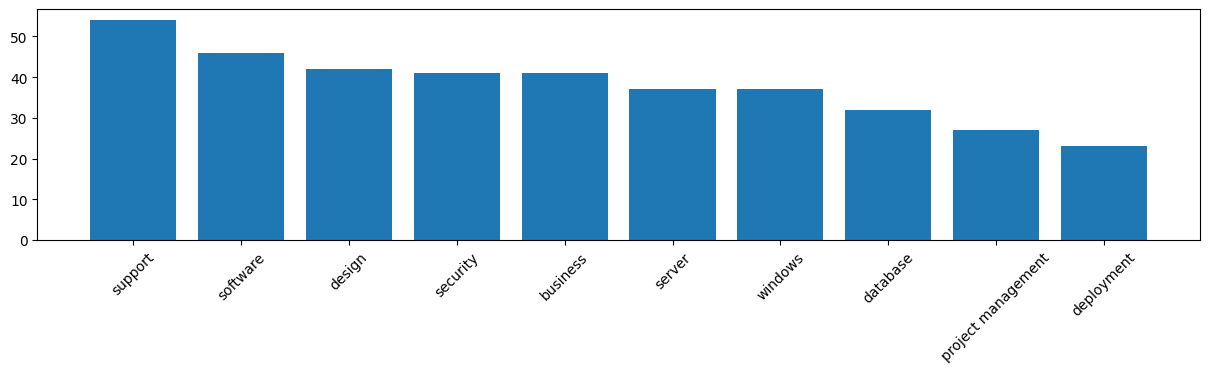

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [25]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [26]:
doc = nlp(text)

In [27]:
# colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"colors": colors}

# displacy.render(doc, style='ent', options=options)

## Task 1: Implementing additional features or improvements inspired by spaCy’s capabilities in natural language processing.

### Task 1.1 identify verbs with their corresponding subjects

In [28]:
from spacy.symbols import nsubj, VERB

# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{oversaw, implement, include, experienced, protect, appreciate, ensure, serve, manage, improve, implement, experience, involve, determine, oversee, communicate, decide, change, cost, set, develop, enjoy, improve, dictate, connect, connect, linkedin, prove, use, receive, need, use, involve, use, facilitate, fast, exist, configure, provide, require, recover, experienced, result, need, visionary, interact, find, dedicated}


### Task 1.2  Identifies the root of the sentence, extracts the subject and its subtree

In [29]:
# Loop through the entire document
for sentence in doc.sents:
    # Find the root of the sentence
    roots = [token for token in sentence if token.head == token]
    
    if not roots:
        # Skip sentences without roots
        continue
    
    root = roots[0]
    
    # Extract the subject and its subtree
    subjects = list(root.lefts)
    
    if not subjects:
        # Skip roots without left children
        continue
    
    subject = subjects[0]
    
    # Print information about the subject and its descendants
    for descendant in subject.subtree:
        assert subject is descendant or subject.is_ancestor(descendant)
        print(descendant.text, descendant.dep_, descendant.n_lefts,
              descendant.n_rights,
              [ancestor.text for ancestor in descendant.ancestors])

information compound 0 0 ['technology', 'director', 'experience', 'technology', 'director', 'change']
technology compound 1 0 ['director', 'experience', 'technology', 'director', 'change']
director nsubj 1 0 ['experience', 'technology', 'director', 'change']
experience compound 1 0 ['technology', 'director', 'change']
information compound 0 0 ['technology', 'director', 'change']
technology compound 2 0 ['director', 'change']
director nsubj 1 3 ['change']
april npadvmod 0 1 ['director', 'change']
1999 nummod 0 0 ['april', 'director', 'change']
january nmod 0 1 ['name', 'state', 'director', 'change']
2015 nummod 0 0 ['january', 'name', 'state', 'director', 'change']
company compound 0 0 ['name', 'state', 'director', 'change']
name compound 2 0 ['state', 'director', 'change']
－ compound 0 0 ['state', 'director', 'change']
city compound 0 0 ['state', 'director', 'change']
state appos 3 0 ['director', 'change']
for prep 0 1 ['director', 'change']
past amod 0 0 ['year', 'for', 'director', 'c

### Task 1.3 Using spaCy's linguistic annotations to analyze the sentence structure, specifically focusing on the subject and its descendants.

In [30]:
# Loop through the entire document
for sentence in doc.sents:
    # Find the root of the sentence
    roots = [token for token in sentence if token.head == token]

    if not roots:
        # Skip sentences without roots
        continue

    root = roots[0]

    # Extract the subject and its subtree
    subjects = list(root.lefts)

    if not subjects:
        # Skip roots without left children
        continue

    subject = subjects[0]

    # Print information about the subject and its descendants
    print("\nSentence Structure:")
    print(f"Root: {root.text} (POS: {root.pos_}, Dep: {root.dep_})")

    for descendant in subject.subtree:
        assert subject is descendant or subject.is_ancestor(descendant)
        print(f"- Token: {descendant.text} | POS: {descendant.pos_} | Dep: {descendant.dep_}")
        print(f"  - Left children: {descendant.n_lefts}")
        print(f"  - Right children: {descendant.n_rights}")
        print(f"  - Ancestors: {[ancestor.text for ancestor in descendant.ancestors]}")



Sentence Structure:
Root: change (POS: VERB, Dep: ROOT)
- Token: information | POS: NOUN | Dep: compound
  - Left children: 0
  - Right children: 0
  - Ancestors: ['technology', 'director', 'experience', 'technology', 'director', 'change']
- Token: technology | POS: NOUN | Dep: compound
  - Left children: 1
  - Right children: 0
  - Ancestors: ['director', 'experience', 'technology', 'director', 'change']
- Token: director | POS: NOUN | Dep: nsubj
  - Left children: 1
  - Right children: 0
  - Ancestors: ['experience', 'technology', 'director', 'change']
- Token: experience | POS: NOUN | Dep: compound
  - Left children: 1
  - Right children: 0
  - Ancestors: ['technology', 'director', 'change']
- Token: information | POS: NOUN | Dep: compound
  - Left children: 0
  - Right children: 0
  - Ancestors: ['technology', 'director', 'change']
- Token: technology | POS: NOUN | Dep: compound
  - Left children: 2
  - Right children: 0
  - Ancestors: ['director', 'change']
- Token: director | PO

### Task 1.4 Identifying linguistic features of each token

In [31]:
# Loop through each token in the document
for token in doc:
    # Print various information about the token
    print(
        token.text,         # The original text of the token
        token.lemma_,       # The base or root form of the token's word
        token.pos_,         # Part-of-speech (POS) tag
        token.tag_,         # Detailed POS tag
        token.dep_,         # Syntactic dependency relation
        token.shape_,       # Word shape (capitalization, punctuation, digits)
        token.is_alpha,     # True if the token consists of alphabetic characters
        token.is_stop       # True if the token is a stop word
    )


information information NOUN NN compound xxxx True False
technology technology NOUN NN compound xxxx True False
director director NOUN NN nsubj xxxx True False
experience experience NOUN NN compound xxxx True False
information information NOUN NN compound xxxx True False
technology technology NOUN NN compound xxxx True False
director director NOUN NN nsubj xxxx True False
april april PROPN NNP npadvmod xxxx True False
1999 1999 NUM CD nummod dddd False False
january january PROPN NNP nmod xxxx True False
2015 2015 NUM CD nummod dddd False False
company company NOUN NN compound xxxx True False
name name NOUN NN compound xxxx True True
－ － PROPN NNP compound － False False
city city NOUN NN compound xxxx True False
state state NOUN NN appos xxxx True False
for for ADP IN prep xxx True True
past past ADJ JJ amod xxxx True False
sixteen sixteen NUM CD nummod xxxx True False
year year NOUN NN pobj xxxx True False
i I PRON PRP compound x True True
leader leader NOUN NN nsubj xxxx True False
c

### Task 1.5 Getting morphological information

In [32]:
# Loop through each token in the document
for token in doc:
    # Print morphological information for the token
    print(
        f"Token: {token.text}",           # Token text
        f"Morphological Features: {token.morph}",  # Morphological features
        f"PronType: {token.morph.get('PronType')}"  # PronType information
    )

Token: information Morphological Features: Number=Sing PronType: []
Token: technology Morphological Features: Number=Sing PronType: []
Token: director Morphological Features: Number=Sing PronType: []
Token: experience Morphological Features: Number=Sing PronType: []
Token: information Morphological Features: Number=Sing PronType: []
Token: technology Morphological Features: Number=Sing PronType: []
Token: director Morphological Features: Number=Sing PronType: []
Token: april Morphological Features: Number=Sing PronType: []
Token: 1999 Morphological Features: NumType=Card PronType: []
Token: january Morphological Features: Number=Sing PronType: []
Token: 2015 Morphological Features: NumType=Card PronType: []
Token: company Morphological Features: Number=Sing PronType: []
Token: name Morphological Features: Number=Sing PronType: []
Token: － Morphological Features: Number=Sing PronType: []
Token: city Morphological Features: Number=Sing PronType: []
Token: state Morphological Features: Nu

## 7. Let's load the PDF - add some realism

In [53]:
from PyPDF2 import PdfReader

reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()

### 1.6 Finding Names better

In [54]:
entities = get_entities(text)
entities


{'PERSON': 'Cheng, Ren, Java, Z., J., W., Chaklam Silpasuwanchai, Akaranee, Niksirat',
 'GPE': 'Silpasuwanchai, Thailand, Mobile, Japan, KS., Bangkok',
 'SKILL': 'Python, localization, Framework, Google, Computer Science, question answering, AI, deep learning, Engineering, Algorithms',
 'ORG': 'Education\n•Kochi University of Technology Kochi, Wang, Department of Statistics, Institute of Technology Pathumthani, J., Oulasvirta, A., GPA, International University Bangkok, •Asian Institute of Technology Pathumthani, PyTorch, School of Engineering and Technology, S., Jokinen, Thailand\nFaculty, •Non-Invasive Blood Glucose Measuring, •Kasetsart University, •Sirindhorn International Institute of Technology Pathumthani, University of Technology Kochi, Physical Eng Express, Computer-Human Interaction, Pananookooln, Social Media, SpringBoot, Hypothesis Testing, Computer Science, Faculty of Business and Technology, Machine/Deep Learning, Natural Language Processing, Software Engineering, •Medical

In [55]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)
pattern = [
    {"POS": "PROPN",  # person's name should be a proper noun
     "OP": "{2}",  # person's name usually consists of 2 parts; first name and last name (in some scenario, 3 if a person has middle name)
     "ENT_TYPE": "PERSON"  # person's name is of 'PERSON' entity type|
    },
]
matcher.add("PERSON NAME", [pattern], greedy="LONGEST")


matches = matcher(doc)
matches.sort(key = lambda x: x[1])

person_names = []

for match in matches:
    person_names.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

person_names = list(set(person_names))
person_names

[('oulasvirta a.', 'PERSON NAME'),
 ('sarcar s.', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('jokinen j.', 'PERSON NAME'),
 ('pananookooln c.', 'PERSON NAME'),
 ('niksirat ks', 'PERSON NAME'),
 ('wang z.', 'PERSON NAME'),
 ('silpasuwanchai c.', 'PERSON NAME'),
 ('akaranee j.', 'PERSON NAME'),
 ('c. ren', 'PERSON NAME')]

In [56]:
entities = []

for match in matches:
    entities.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

entities = list(set(entities))
entities

[('oulasvirta a.', 'PERSON NAME'),
 ('sarcar s.', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('jokinen j.', 'PERSON NAME'),
 ('pananookooln c.', 'PERSON NAME'),
 ('niksirat ks', 'PERSON NAME'),
 ('wang z.', 'PERSON NAME'),
 ('silpasuwanchai c.', 'PERSON NAME'),
 ('akaranee j.', 'PERSON NAME'),
 ('c. ren', 'PERSON NAME')]

### 1.7 Extracting Email and URL

In [58]:
matcher.add("EMAIL", [[{"LIKE_EMAIL": True}]], greedy="LONGEST")
matcher.add("URL", [[{"LIKE_URL": True}]], greedy="LONGEST")

In [59]:
doc = nlp(text)
text = preprocessing(text)
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)